In [ ]:
import os
import json
import argparse
import pandas as pd
from pymongo import MongoClient
from reportparse.reader.base import BaseReader
from reportparse.annotator.base import BaseAnnotator
from reportparse.util.settings import LAYOUT_NAMES, LEVEL_NAMES
import matplotlib.pyplot as plt
import seaborn as sns
import argparse


# parser = argparse.ArgumentParser(description="Process and analyze climate-related text from a PDF.")
# parser.add_argument("--input", type=str, default="./reportparse/asset/example.pdf", help="Path to input PDF file.")
# parser.add_argument("--output", type=str, default="./cli_results", help="Directory to save output files.")

# args = parser.parse_args()
out= "./cli_results"
os.makedirs(out, exist_ok=True)
inp ="./reportparse/asset/example.pdf"

reader = BaseReader.by_name("pymupdf")()

document = reader.read(input_path=inp)

document = BaseAnnotator.by_name("climate")().annotate(document=document)
document = BaseAnnotator.by_name("climate_commitment")().annotate(document=document)
document = BaseAnnotator.by_name("climate_specificity")().annotate(document=document)

json_output_path = os.path.join(out, os.path.basename(inp) + ".json")
document.save(json_output_path)

df = document.to_dataframe(level="block")
df_2 = document.to_dataframe(level="page")

print(df)

# # eda
print(df.describe())
print()

print(df.info())
print()

print(df.head())
print()

print(df.tail())
print()

print(df.columns)
print()

print(df.index)
print()

climate_df = df[df["climate"] == "yes"]

cti_df = climate_df.groupby("page_id").apply(
    lambda x: pd.Series({
        "commit_total": (x["climate_commitment"] == "yes").sum(),
        "commit_non_spec": ((x["climate_commitment"] == "yes") & (x["climate_specificity"] == "non")).sum()
    })
)

# Calculate CTI
cti_df["CTI"] = cti_df["commit_non_spec"] / cti_df["commit_total"]
cti_df["CTI"].fillna(0, inplace=True)

cti_df.reset_index(inplace=True)

print(cti_df)

# for the whole document
total_commit = (climate_df["climate_commitment"] == "yes").sum()
total_commit_non_spec = ((climate_df["climate_commitment"] == "yes") & (climate_df["climate_specificity"] == "non")).sum()
overall_cti = total_commit_non_spec / total_commit if total_commit > 0 else 0

print(f"Overall Cheap Talk Index (CTI): {overall_cti:.4f}")

cti_results = {
    "page_cti_scores": cti_df.set_index("page_id")["CTI"].to_dict(),
    "overall_cti": overall_cti
}
input_base = os.path.basename(inp)
output_path = f"./cli_results/{input_base}_cti_scrores.json"

with open(output_path, "w") as f:
    json.dump(cti_results, f, indent=4)

print(f"CTI scores saved to {output_path}")


page_ids = list(cti_results["page_cti_scores"].keys())
page_scores = list(cti_results["page_cti_scores"].values())

plt.figure(figsize=(12, 6))

sns.barplot(x=page_ids, y=page_scores, palette="Blues_r")

plt.axhline(y=overall_cti, color='red', linestyle='--', label=f'Overall CTI: {overall_cti:.4f}')

plt.xlabel("Page ID")
plt.ylabel("CTI Score")
plt.title("Cheap Talk Index (CTI) per Page")
plt.xticks(rotation=90)  
plt.legend()

plt.tight_layout()
plt.show()

# save plot in the same dir
plt.savefig(f"./cli_results/{input_base}_cti_plot.png")


NameError: name 'args' is not defined

In [ ]:
from logging import getLogger
import traceback
import argparse
import os
import pandas as pd
import ollama
import chromadb
import requests
from reportparse.structure.document import Document
import re
from reportparse.db_rag.db import ChromaDBHandler
from langchain_groq import ChatGroq

logger = getLogger(__name__)


document = Document.from_json_file('example.pdf.json')
df = document.to_dataframe(level='page')
print(df)
print()
print(df.columns)

print()
# print first pass chroma result and web rag result for page 1
page_1 = document.pages[0]
# print(page_1.get_annotation("chroma"))
# print(page_1.get_annotation("web_rag"))

# print the same from df
# print(df.loc[0, "chroma_result"])

      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  4405.499776   
1  page_idx_1         1  4405.499776  4405.499776   
2  page_idx_2         2  4405.499776  4405.499776   
3  page_idx_3         3  4405.499776  4405.499776   
4  page_idx_4         4  4405.499776  4405.499776   
5  page_idx_5         5  4405.499776  4405.499776   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   
5  054 Hitachi Sustainability Report 2023 Environ...   

                                          First pass  \
0  Potential greenwashing claim: Hitachi's carbon...   
1  Potential greenwashing claim: Improve water us...   
2  Potential greenwashing claim: Achieving a Deca...   
3  Potentia

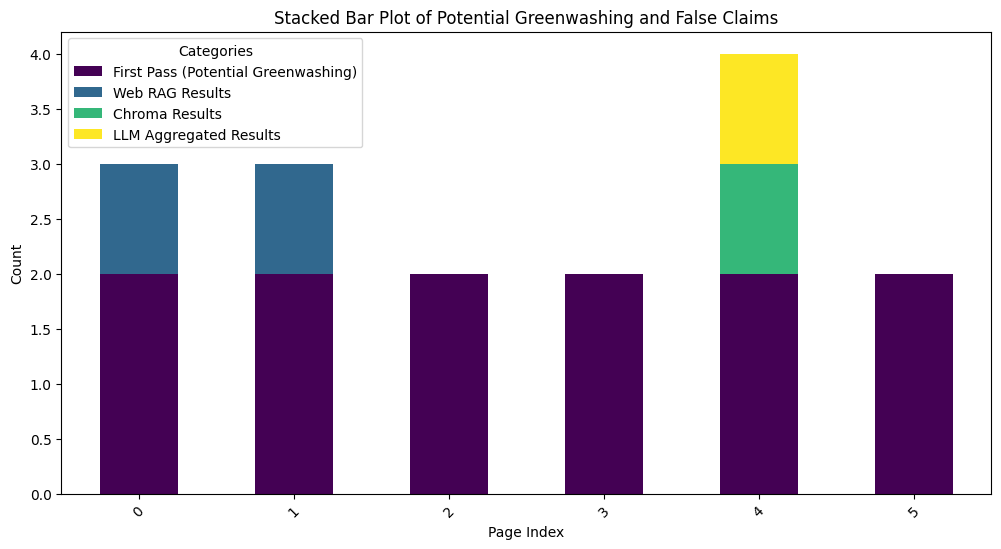

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

first_pass_count = df["First pass"].str.count("Potential greenwashing", flags=re.IGNORECASE).groupby(df.index).sum()

# Define function to count occurrences of "PARTIALLY FALSE" and "FALSE"
def count_false_statements(columns, df):
    return df[columns].apply(lambda col: col.str.contains("Result of the statement: PARTIALLY FALSE|Result of the statement: FALSE", na=False)).sum(axis=1)

web_rag_count = count_false_statements(["web_rag_result", "web_rag_result_2"], df)
chroma_count = count_false_statements(["chroma_result", "chroma_result_2"], df)
llm_agg_count = count_false_statements(["aggregator_result", "aggregator_result_2"], df)

plot_df = pd.DataFrame({
    "First Pass (Potential Greenwashing)": first_pass_count,
    "Web RAG Results": web_rag_count,
    "Chroma Results": chroma_count,
    "LLM Aggregated Results": llm_agg_count
})

ax = plot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Page Index")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Potential Greenwashing and False Claims")
plt.legend(title="Categories")
plt.xticks(np.arange(len(plot_df.index)), plot_df.index, rotation=45)
plt.show()


,Company,Year,Url,Claim,Accusation,Company_description,Type,certificates,Unnamed: 8
0,Oatly,2022.0,https://www.oatly.com/en-gb/helpdad,Oatly generates 73% less CO2e VS cows milk,NaN,"Oatly Group AB, an oatmilk company, provides a...",GREENWASHING,NaN,NaN
1,Ryanair,2019.0,https://www.asa.org.uk/rulings/ryanair-ltd-cas...,The press ad featured text which stated “Europ...,NaN,"Ryanair Holdings plc, together with its subsid...",GREENWASHING,NaN,NaN
2,Ryanair,2019.0,https://www.asa.org.uk/rulings/ryanair-ltd-cas...,The TV ad featured a voice-over which stated “...,While we considered the claims in the ads woul...,"Ryanair Holdings plc, together with its subsid...",GREENWASHING,NaN,NaN
3,Adidas,2021.0,https://greenwash.com/brands/adidas/,"Stan Smith Forever. 100% iconic, 50% recycled","The brand claimed the shoes are 100% iconic, 5...","adidas AG, together with its subsidiaries, des...",GREENWASHING,NaN,NaN
4,Asos,2022.0,https://goodonyou.eco/greenwashing-examples/,Style meets sustainability in our innovative n...,These “greener” clothing ranges represent a ti...,ASOS Plc operates as an online fashion retaile...,GREENWASHING,NaN,NaN
...,...,...,...,...,...,...,...,...,...
93,NaN,NaN,NaN,NaN,NaN,NaN,NOT_GREENWASHING,NaN,NaN
94,NaN,NaN,NaN,NaN,NaN,NaN,NOT_GREENWASHING,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NOT_GREENWASHING,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NOT_GREENWASHING,NaN,NaN


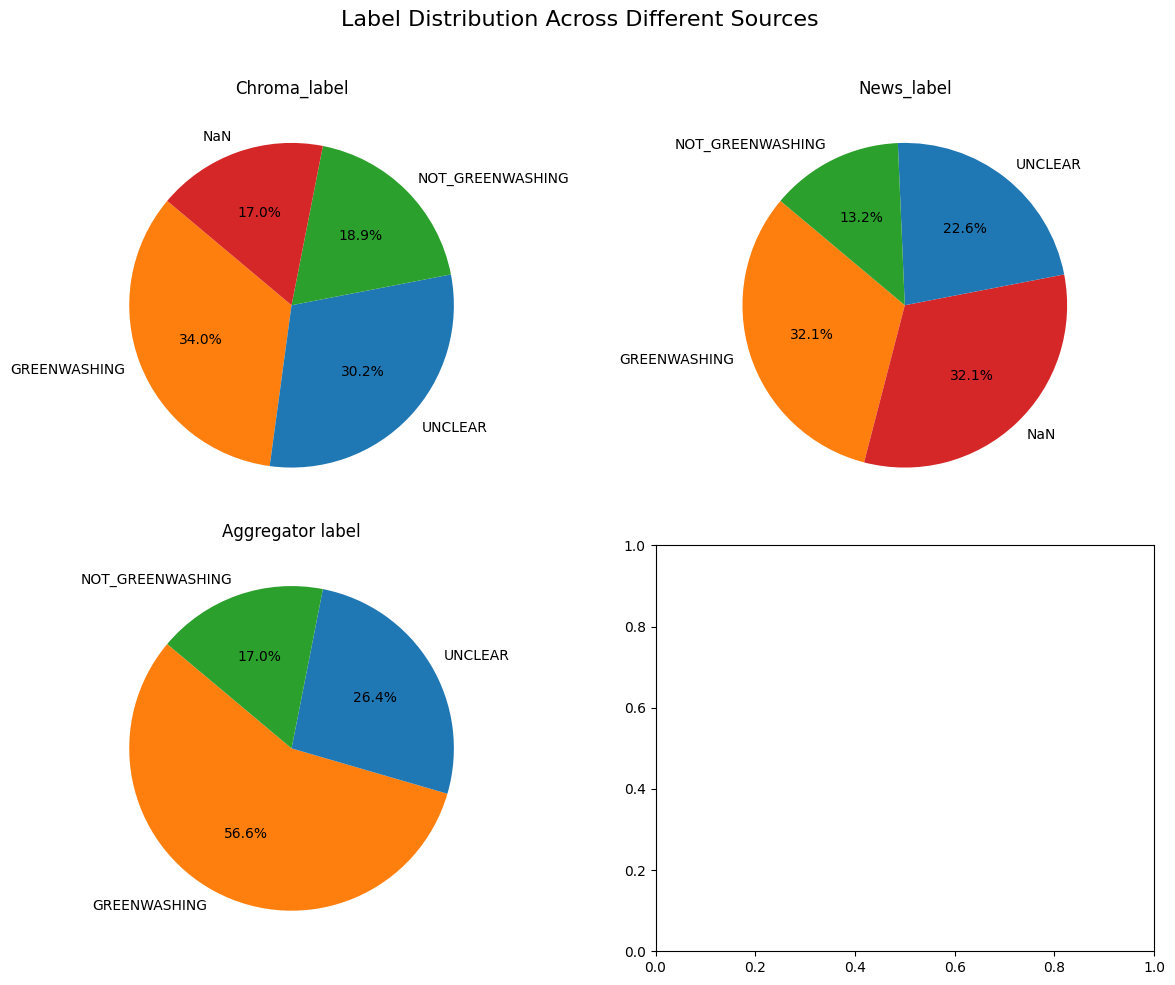

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV file
df = pd.read_csv("gw_result_exp2.csv")
df2 = pd.read_csv("Greenwashing_claims_esg_reports.csv")
df2['Type'] = df2['Type'].replace({
    'greenwash': 'GREENWASHING',
    'not greenwash': 'NOT_GREENWASHING'
})

df2 = df2.dropna(subset=['Type'])
display(df2)

# Define the label columns to visualize
label_columns = [
    "Chroma_label",
    #"Web_rag_label",
    "News_label",
    "Aggregator label"
]

# Collect all unique labels across all label columns (including NaNs)
all_labels_series = pd.concat([df[col] for col in label_columns])
unique_labels = all_labels_series.dropna().unique().tolist()
unique_labels.append('NaN')  # Add NaN explicitly for consistent coloring

# Assign consistent colors using a seaborn palette
palette = sns.color_palette("tab10", len(unique_labels))
color_map = dict(zip(unique_labels, palette))

# Set up a single figure with 4 subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Generate pie plots
for i, col in enumerate(label_columns):
    value_counts = df[col].value_counts(dropna=False)
    labels = ['NaN' if pd.isna(label) else label for label in value_counts.index]
    colors = [color_map[label] for label in labels]
    
    axes[i].pie(value_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f"{col}")

# Layout adjustments
plt.suptitle("Label Distribution Across Different Sources", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()


In [ ]:
import pandas as pd

df1 = pd.read_csv("gw_result_exp2.csv") #HERE
df2 = pd.read_csv("Greenwashing_claims_esg_reports.csv")
df2['id'] = df2.index
df2['Type'] = df2['Type'].replace({
    'greenwash': 'GREENWASHING',
    'not greenwash': 'NOT_GREENWASHING'
})
df2 = df2.dropna(subset=['Type'])


df_merged = pd.merge(df, df2, on='id', how='inner')
df_merged = df_merged[['id', 'Type', 'Chroma_label', 'Web_rag_label', 'News_label', 'Aggregator label']]
df_merged = df_merged[df_merged['News_label'] != 'UNCLEAR'] #HEREEEEEEEEEEEEE


import pandas as pd
from sklearn.metrics import accuracy_score
 
# Sample DataFrame (replace this with your actual data)
df = df_merged.dropna(subset=['News_label']) #HEREEEEEEEEEEEEEEE

# Ground truth and predicted values
y_true = df['Type']
y_pred = df['News_label']  #HEREEEEEEEEEE

#remove this if you want to test the Aggregator_label

# Unique labels
labels = y_true.unique()

# Per-label accuracy
label_accuracies = {}
for label in labels:
    # Only consider rows where the true label is this label
    mask = y_true == label
    correct = (y_pred[mask] == y_true[mask]).sum()
    total = mask.sum()
    label_accuracies[label] = correct / total if total > 0 else 0.0

# Overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)

# Print results
print("Per-label accuracies:")
for label, acc in label_accuracies.items():
    print(f"{label}: {acc:.2%}")

print(f"\nOverall accuracy for Web_rag Label: {overall_accuracy:.2%}")




#read RAG results

df1 = df1.merge(df_merged[['id', 'Type']], on='id', how='left')
df1

# Get current column list
cols = list(df1.columns)

# Swap last and second-to-last columns
cols[-2], cols[-1] = cols[-1], cols[-2]

# Reorder DataFrame
df1 = df1[cols]
df1
df1 = df1.rename(columns={'Type': 'Ground Truth'})





Per-label accuracies:
GREENWASHING: 85.71%
NOT_GREENWASHING: 50.00%

Overall accuracy for Web_rag Label: 70.83%


In [ ]:
#hereeeeeeeeeeeeee

import pandas as pd
df1 = pd.read_csv('gw_without_definition.csv')
print(len(df1))
df2 = pd.read_csv('Greenwashing_claims_esg_reports.csv')
df2['Type'] = df2['Type'].replace({
    'greenwash': 'GREENWASHING',
    'not greenwash': 'NOT_GREENWASHING'
})
df2['id'] = df2.index
df_merged = pd.merge(df1, df2[['id','Type']], on='id', how='inner')
#df_merged = df_merged[['id', 'Type', 'Chroma_label', 'Web_rag_label', 'News_label', 'Aggregator label']]



# # Get current column list
# cols = list(df_merged.columns)

# # Swap last and second-to-last columns
# cols[-2], cols[-1] = cols[-1], cols[-2]

# # Reorder DataFrame
# df_merged = df_merged[cols]
# df_merged
df_merged = df_merged.rename(columns={'Type': 'ground_truth'})


df_merged.to_csv('gw_without_definition_final.csv', index=False)




67


In [ ]:
#hereeeeeeeeeeeeeeee
import pandas as pd
import numpy as np
df1 = pd.read_csv('gw_without_definition_final.csv')
df2 = pd.read_csv('experiment_1.csv')
df1 = df1[df1['id'].isin(df2['id'])]
df1.to_csv('gw_without_definition_filtered_final.csv', index=False)


